In [1]:
!pip install astropy

In [73]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
import os

# Define the directory containing the FITS files
directory_path = '/content/comets2'

# List all FITS files in the directory
fits_files = [f for f in os.listdir(directory_path) if f.endswith('.fits')]
print(f"Found {len(fits_files)} FITS files.")


Found 9 FITS files.


In [77]:
# Define a function to process each FITS file
def process_fits(fits_file):
    # Load the image data from a FITS file
    with fits.open(fits_file) as hdul:
        image_data = hdul[0].data

    # Display the original image
    plt.imshow(image_data, cmap='gray')
    plt.colorbar()
    plt.title(f'Original Comet Image: {fits_file}')
    plt.show()

    # Calculate the centroid and peak intensity
    x0, y0 = np.unravel_index(np.argmax(image_data), image_data.shape)
    I0 = image_data[x0, y0]

    # Print centroid and peak intensity
    print(f"--------------------------------------------")
    print(f"Centroid: ({x0}, {y0}), Peak Intensity: {I0}")
    print(f"--------------------------------------------")

    # Generate mesh grids for pixel coordinates
    i, j = np.meshgrid(np.arange(image_data.shape[0]), np.arange(image_data.shape[1]), indexing='ij')

    # Calculate radial distances and angular positions from the centroid
    rho = np.sqrt((i - x0)**2 + (j - y0)**2)
    theta = np.arctan2(j - y0, i - x0)

    # Visualize radial and angular distributions
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(rho, cmap='viridis')
    ax[0].set_title('Radial Distances from Centroid')
    ax[1].imshow(theta, cmap='twilight')
    ax[1].set_title('Angular Positions')
    plt.show()

    return image_data, x0, y0, I0, rho, theta


In [75]:
def fit_model(image_data, rho, theta, I0):
    # Define bins for angular data
    num_bins = 10
    bin_edges = np.linspace(-np.pi, np.pi, num_bins + 1)
    bin_indices = np.digitize(theta, bin_edges) - 1

    alpha_values = []

    for b in range(num_bins):
        mask = bin_indices == b
        rho_bin = rho[mask]
        image_data_bin = image_data[mask]
        if len(rho_bin) > 0:
            popt, _ = curve_fit(lambda r, alpha: I0 * np.exp(-alpha * r), rho_bin, image_data_bin, p0=[0.01])
            alpha_values.append(popt[0])
        else:
            alpha_values.append(np.nan)

    # Fit the cosine model
    theta_midpoints = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    valid = ~np.isnan(alpha_values)
    cosine_params, _ = curve_fit(lambda t, A, theta0: 1 + A * np.cos(t - theta0), theta_midpoints[valid], np.array(alpha_values)[valid], p0=[0.5, 0])

    # Generate model image and compute residuals
    model_image = I0 * np.exp(-((1 + cosine_params[0] * np.cos(theta - cosine_params[1])) * rho))
    residuals = image_data - model_image

    return model_image, residuals, cosine_params


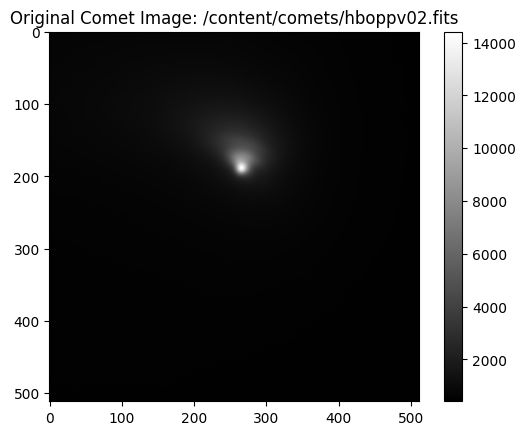

--------------------------------------------
Centroid: (188, 266), Peak Intensity: 14411
--------------------------------------------


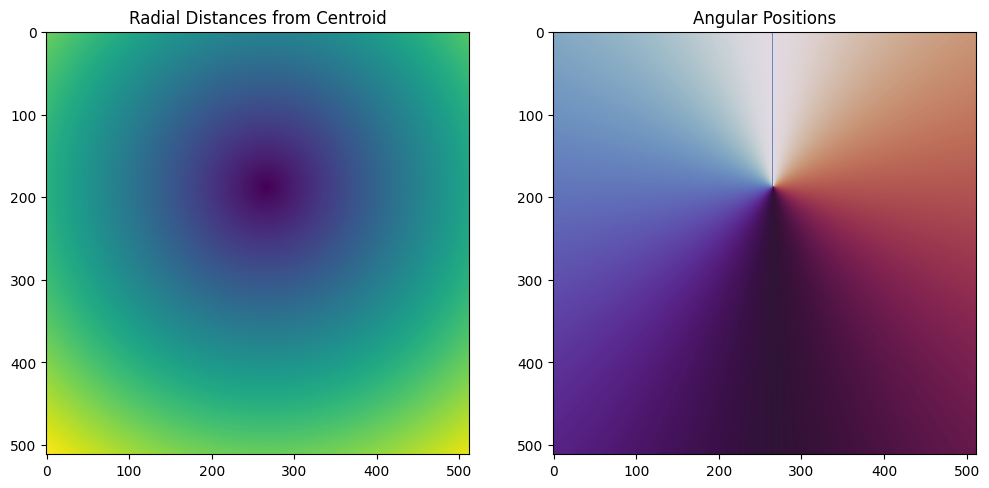

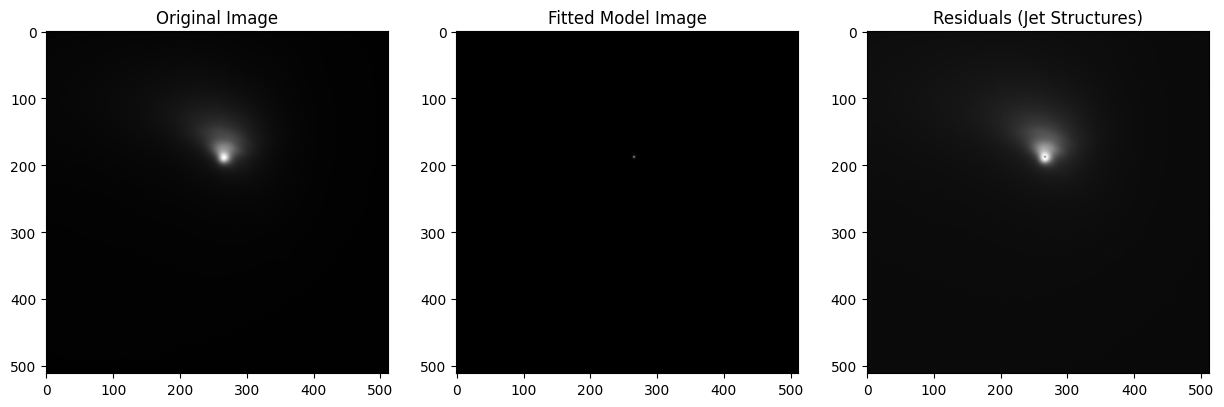

----------------------------------------------------------------
Model Parameters for hboppv02.fits: [ 0.02987637 -0.17778249]
----------------------------------------------------------------


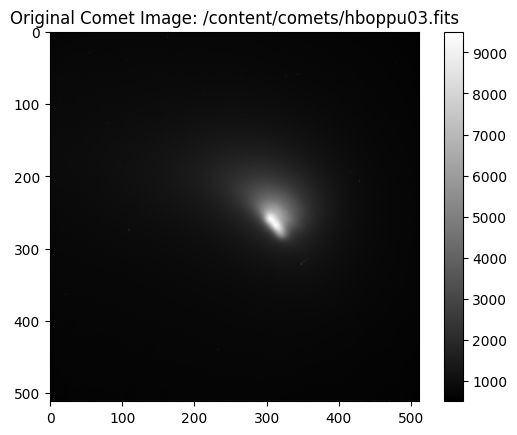

--------------------------------------------
Centroid: (260, 306), Peak Intensity: 9503
--------------------------------------------


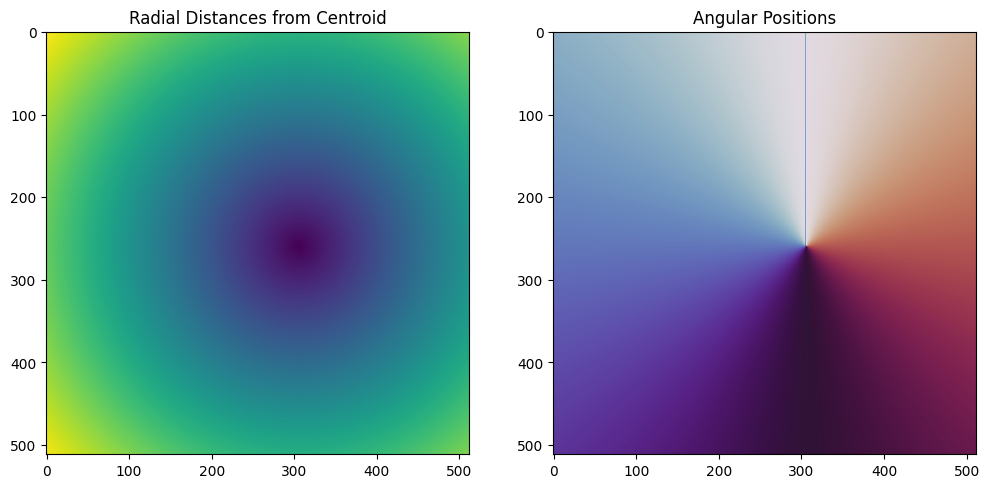

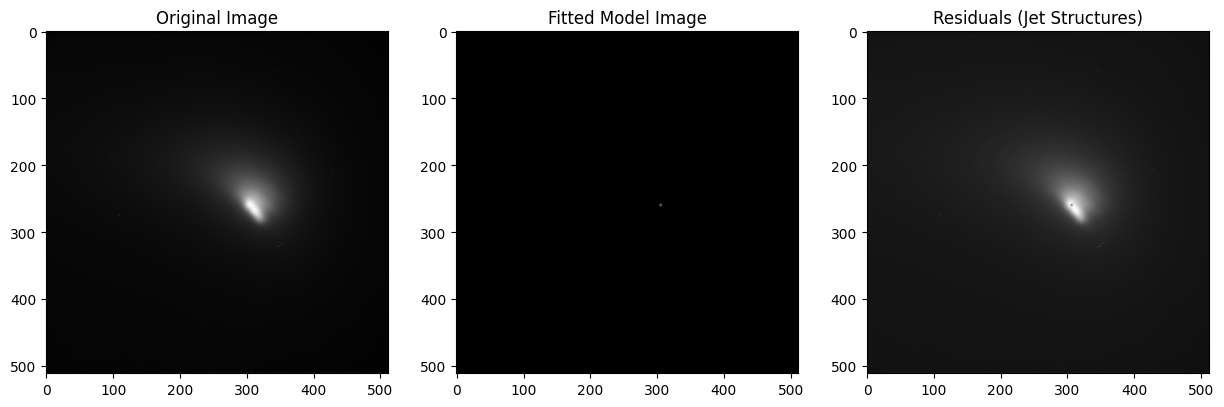

----------------------------------------------------------------
Model Parameters for hboppu03.fits: [ 0.00766654 -0.14517345]
----------------------------------------------------------------


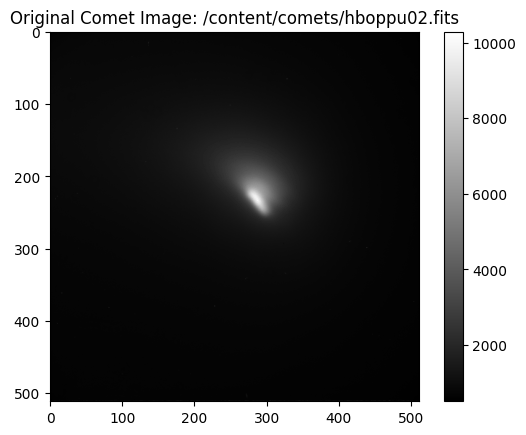

--------------------------------------------
Centroid: (234, 287), Peak Intensity: 10291
--------------------------------------------


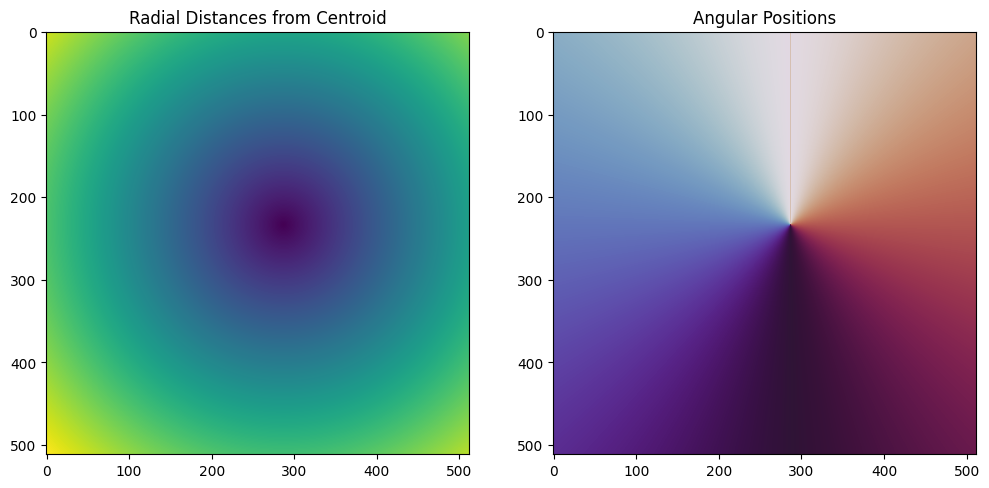

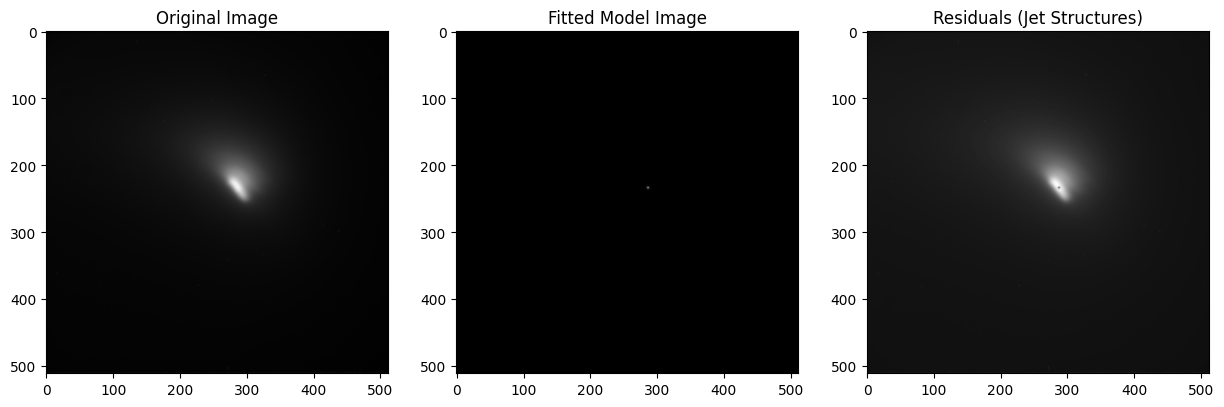

----------------------------------------------------------------
Model Parameters for hboppu02.fits: [ 0.01173226 -0.13580909]
----------------------------------------------------------------


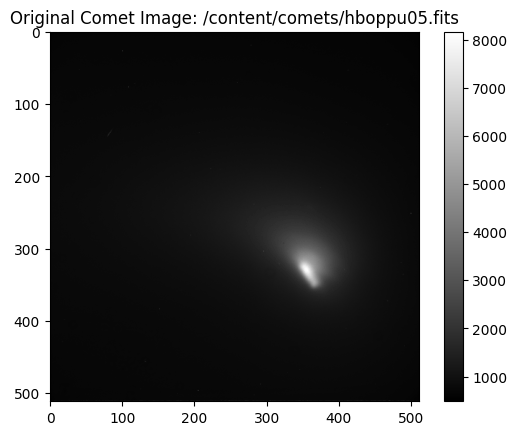

--------------------------------------------
Centroid: (329, 355), Peak Intensity: 8163
--------------------------------------------


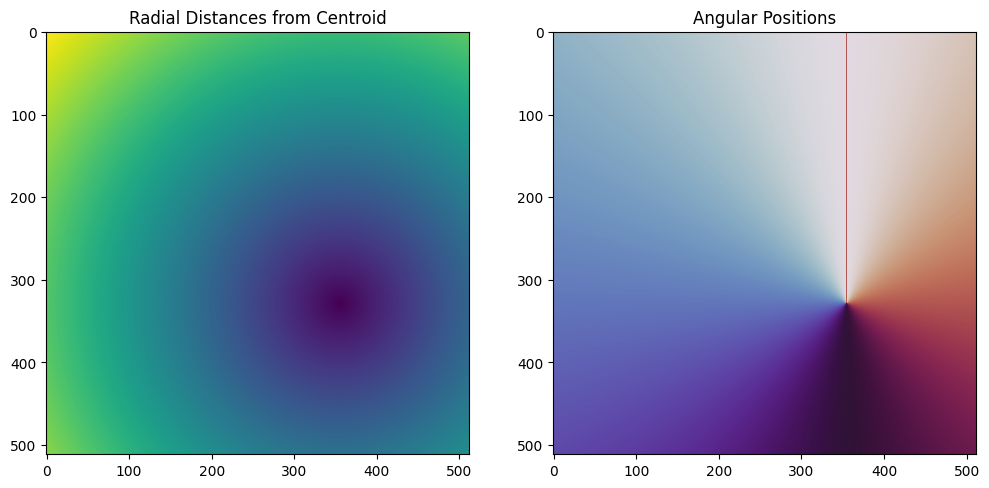

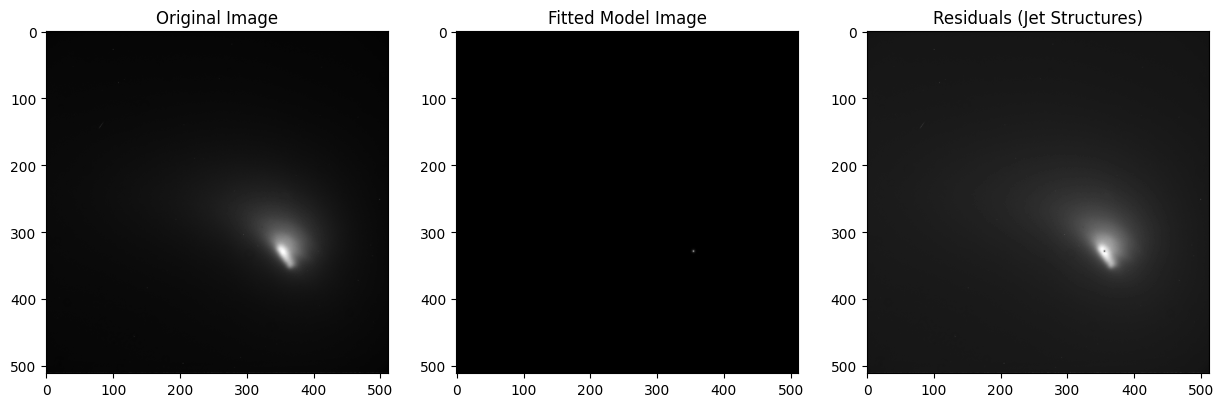

----------------------------------------------------------------
Model Parameters for hboppu05.fits: [0.00768974 0.17161046]
----------------------------------------------------------------


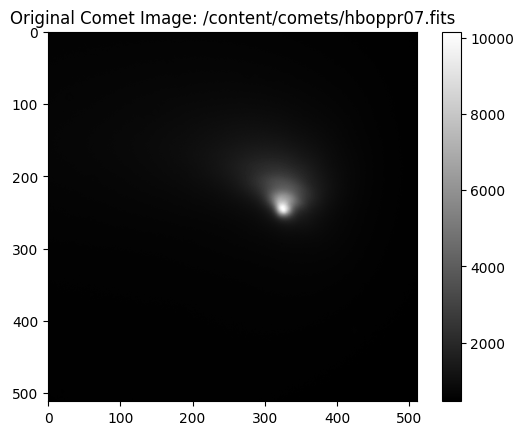

--------------------------------------------
Centroid: (244, 324), Peak Intensity: 10153
--------------------------------------------


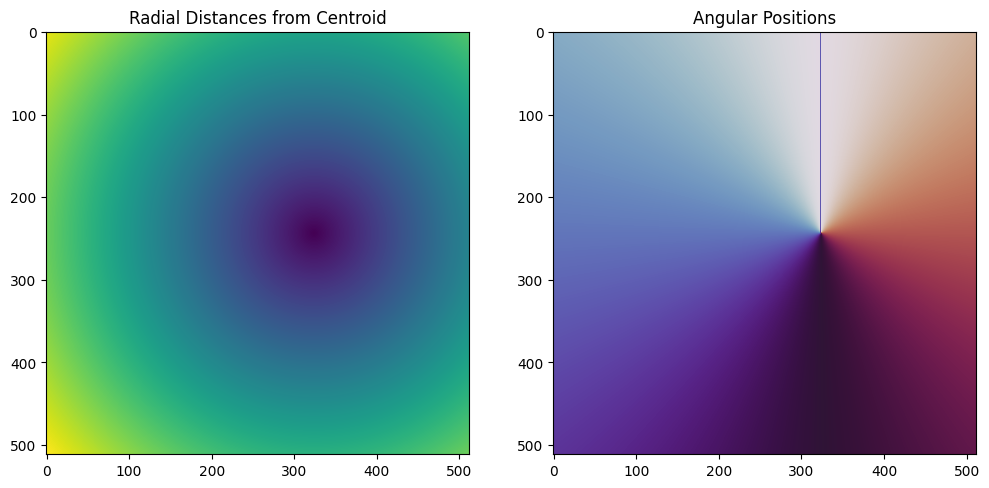

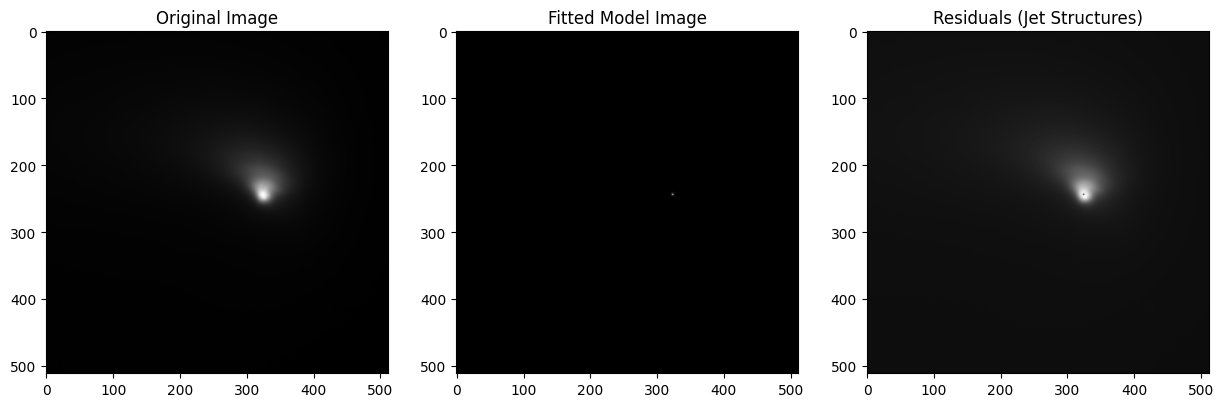

----------------------------------------------------------------
Model Parameters for hboppr07.fits: [ 0.02557902 -0.20235957]
----------------------------------------------------------------


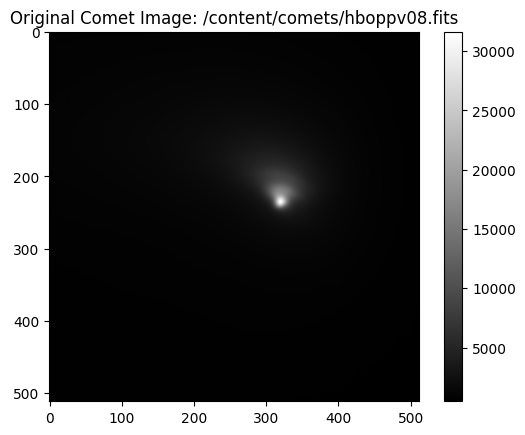

--------------------------------------------
Centroid: (236, 320), Peak Intensity: 31641
--------------------------------------------


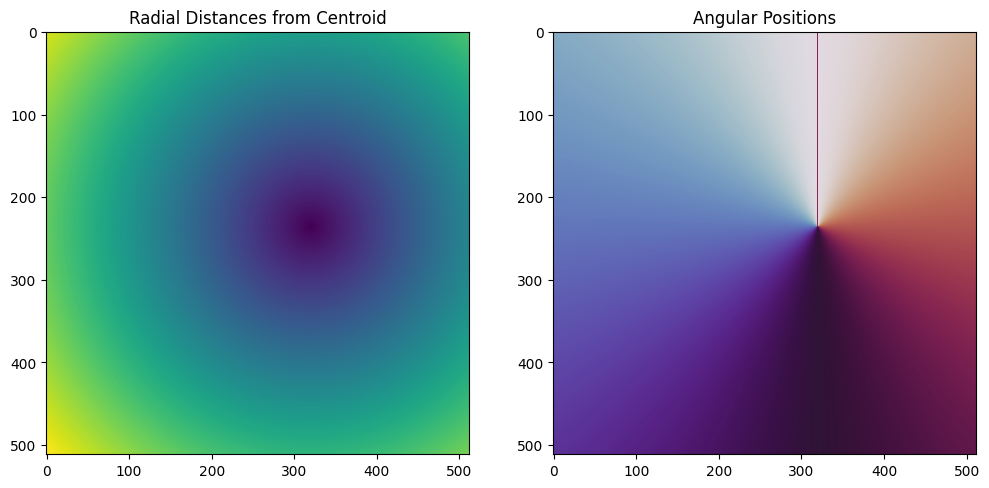

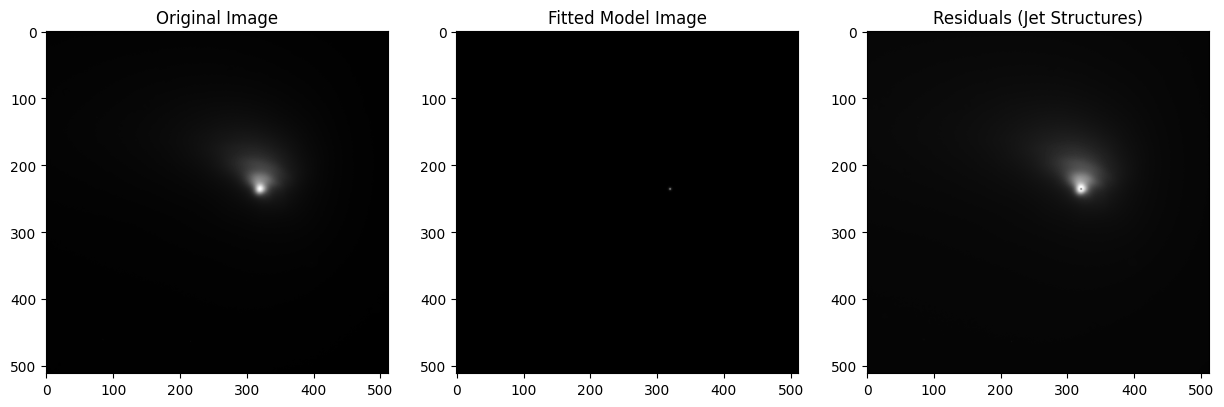

----------------------------------------------------------------
Model Parameters for hboppv08.fits: [ 0.04089941 -0.1727662 ]
----------------------------------------------------------------


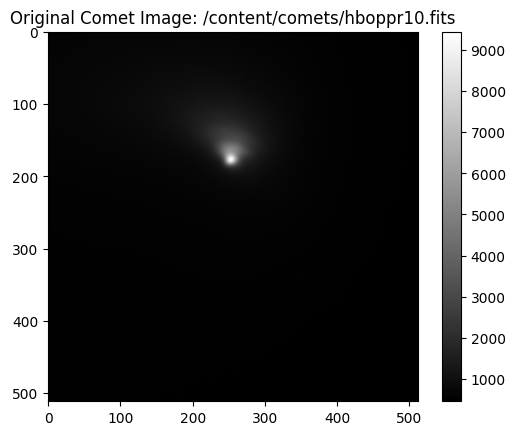

--------------------------------------------
Centroid: (177, 252), Peak Intensity: 9445
--------------------------------------------


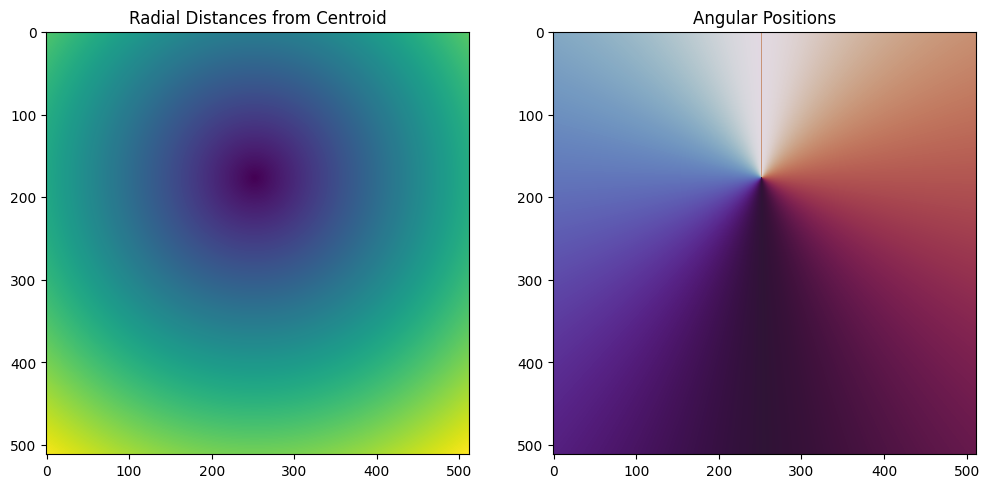

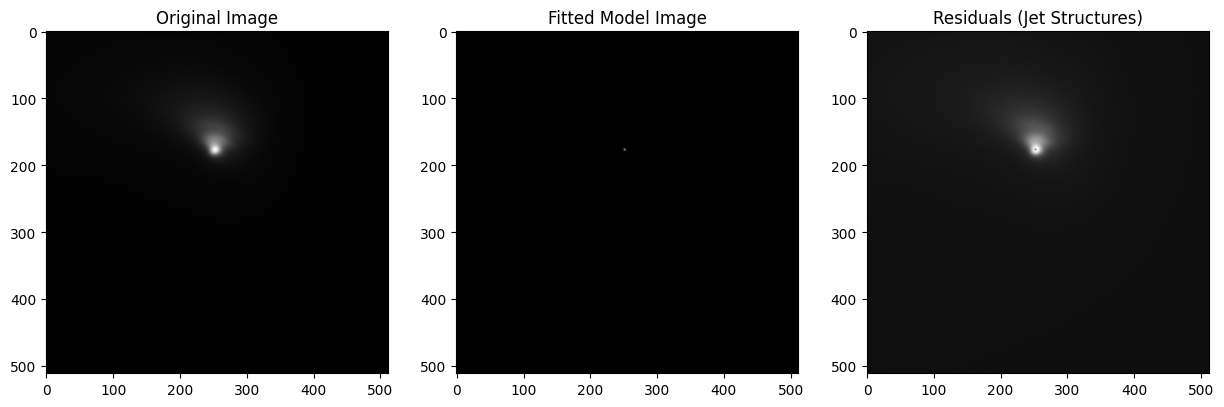

----------------------------------------------------------------
Model Parameters for hboppr10.fits: [ 0.03446541 -0.22364656]
----------------------------------------------------------------


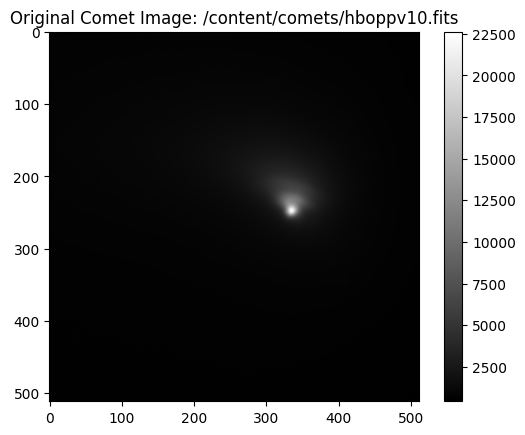

--------------------------------------------
Centroid: (248, 335), Peak Intensity: 22622
--------------------------------------------


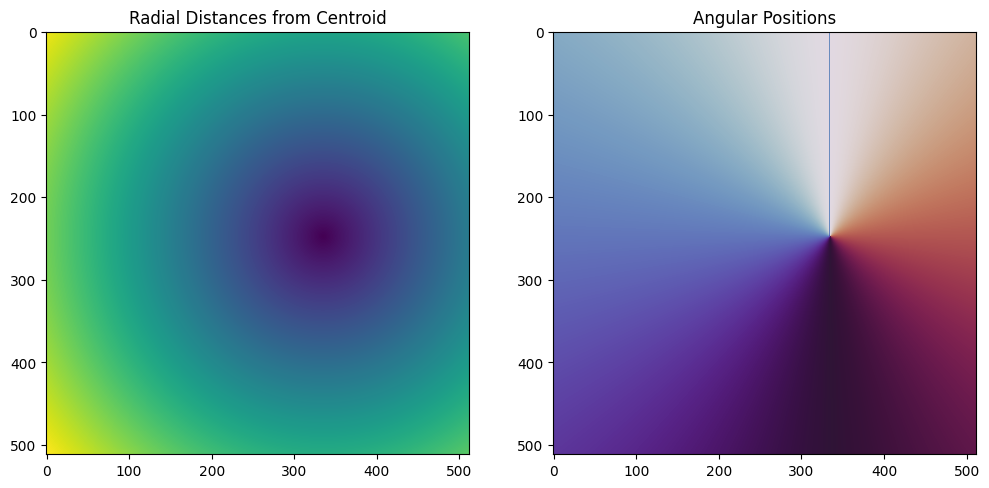

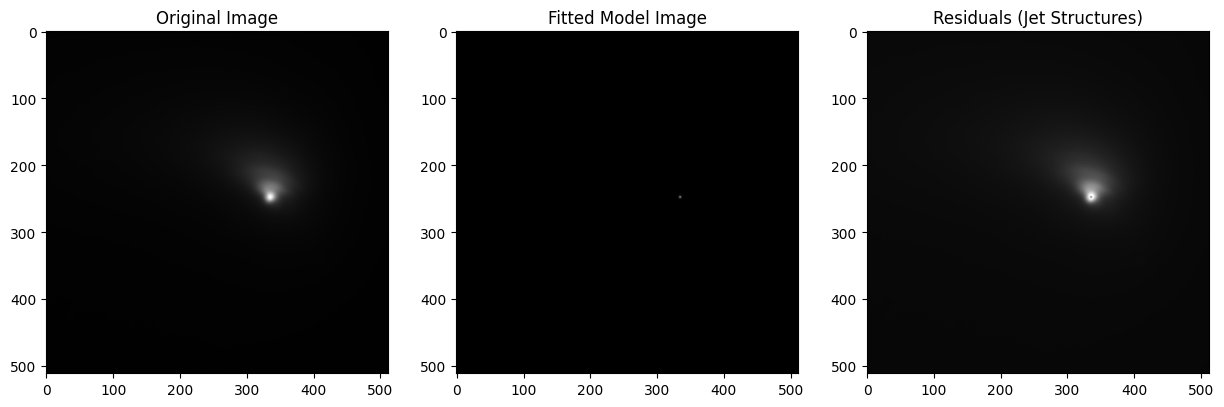

----------------------------------------------------------------
Model Parameters for hboppv10.fits: [ 0.04058815 -0.18871573]
----------------------------------------------------------------


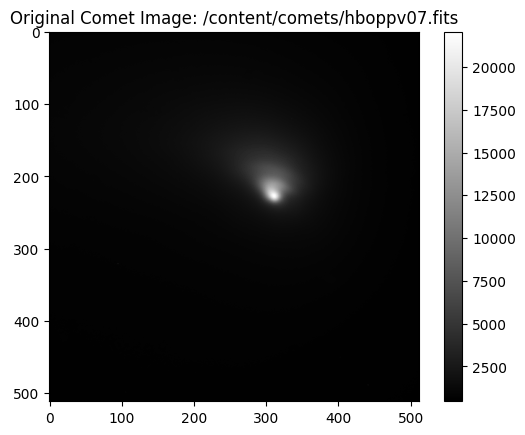

--------------------------------------------
Centroid: (227, 311), Peak Intensity: 22065
--------------------------------------------


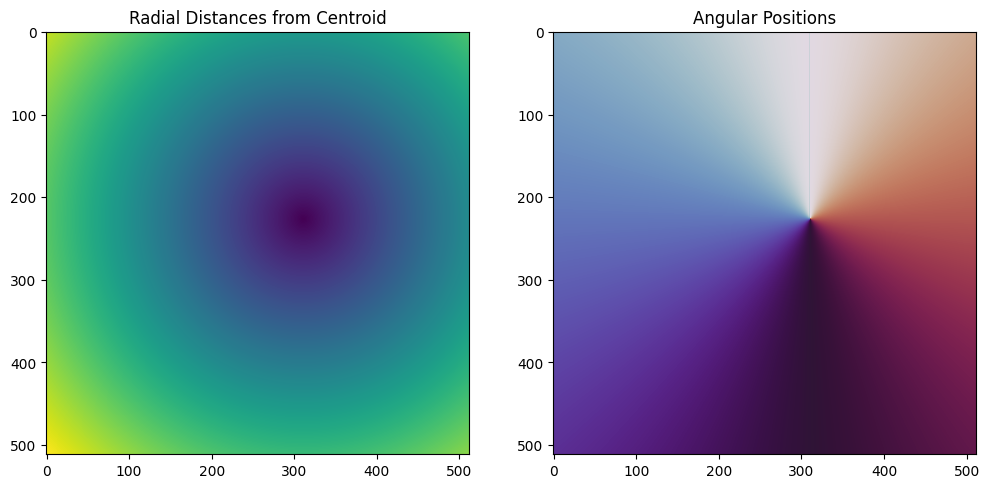

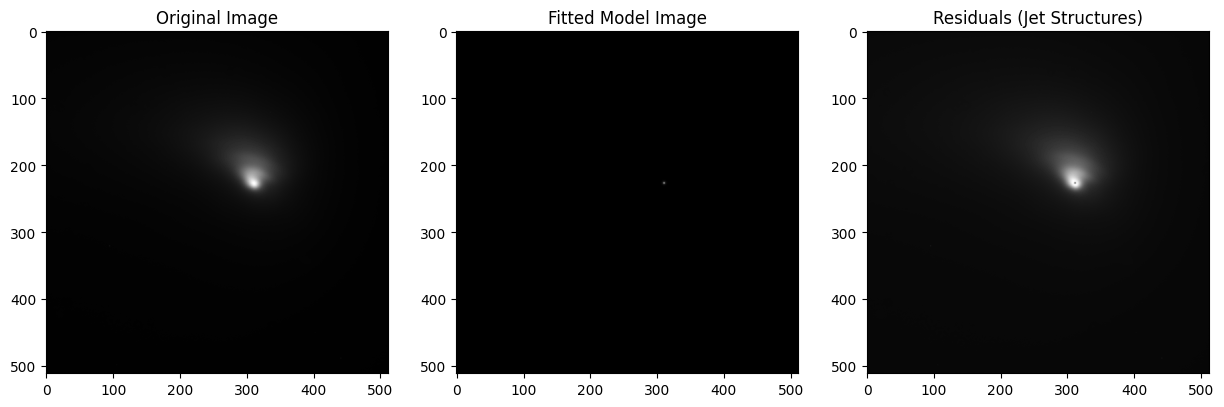

----------------------------------------------------------------
Model Parameters for hboppv07.fits: [ 0.03116139 -0.06010075]
----------------------------------------------------------------


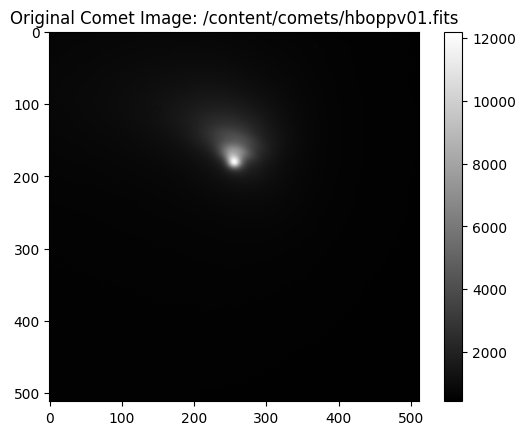

--------------------------------------------
Centroid: (180, 255), Peak Intensity: 12211
--------------------------------------------


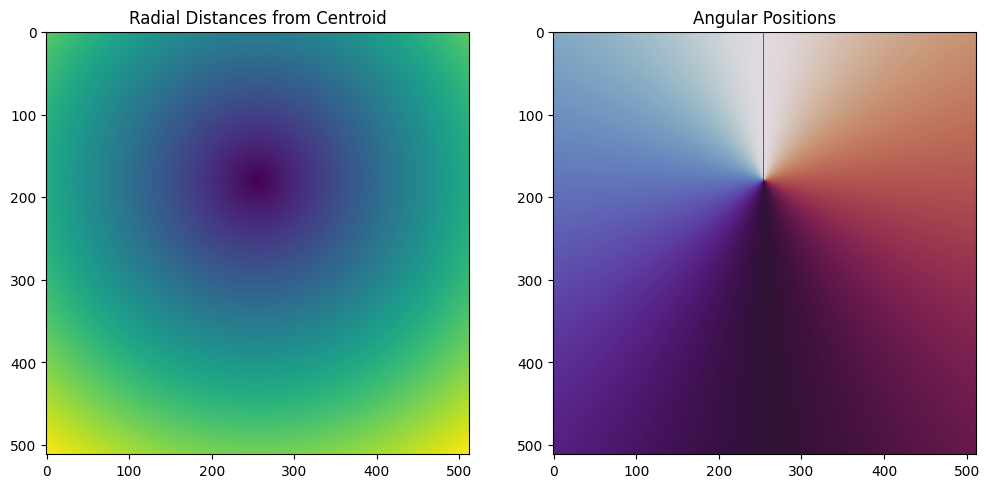

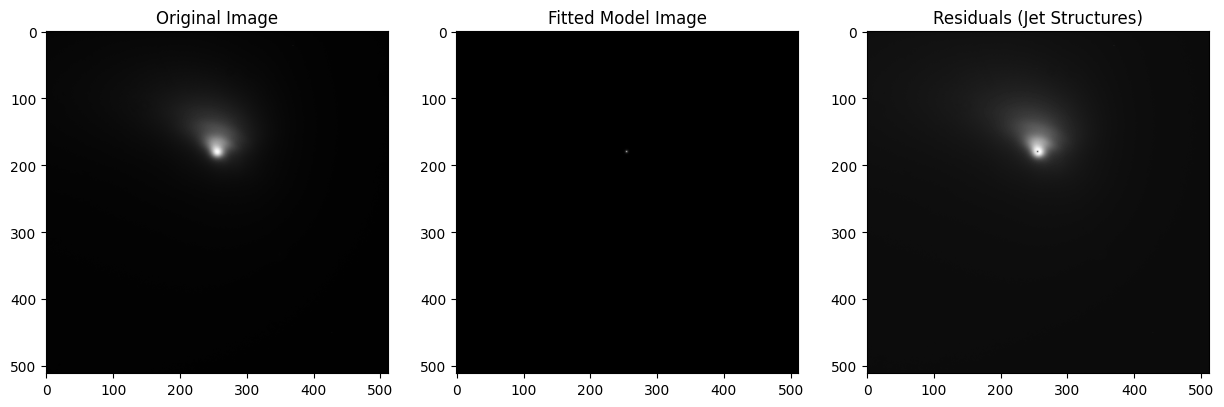

----------------------------------------------------------------
Model Parameters for hboppv01.fits: [ 0.02873871 -0.19572264]
----------------------------------------------------------------


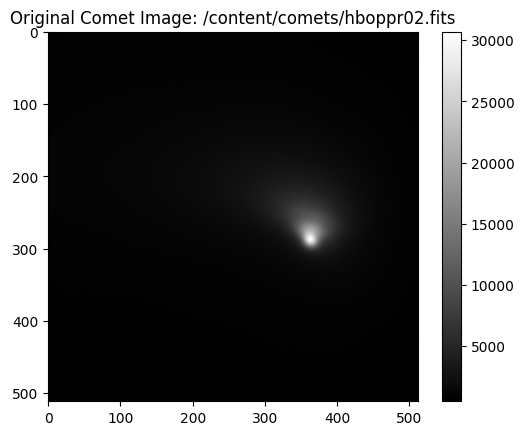

--------------------------------------------
Centroid: (288, 363), Peak Intensity: 30693
--------------------------------------------


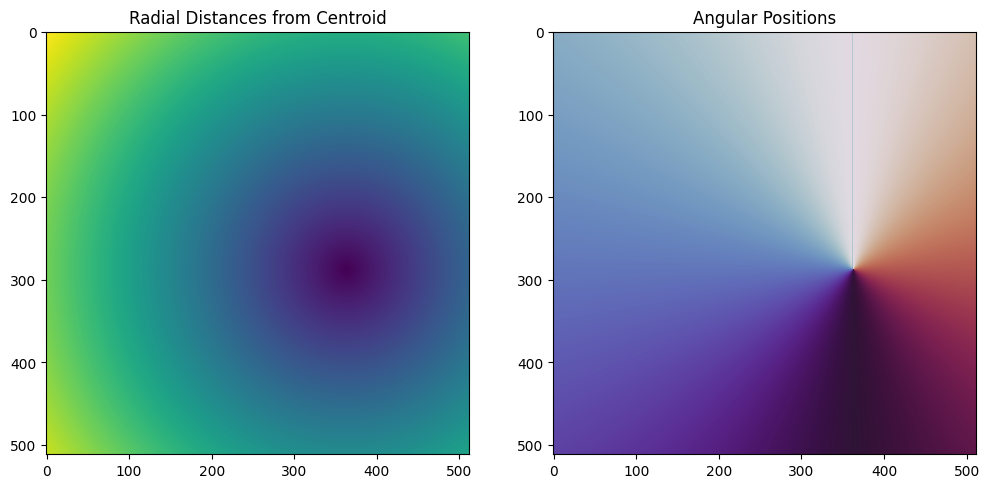

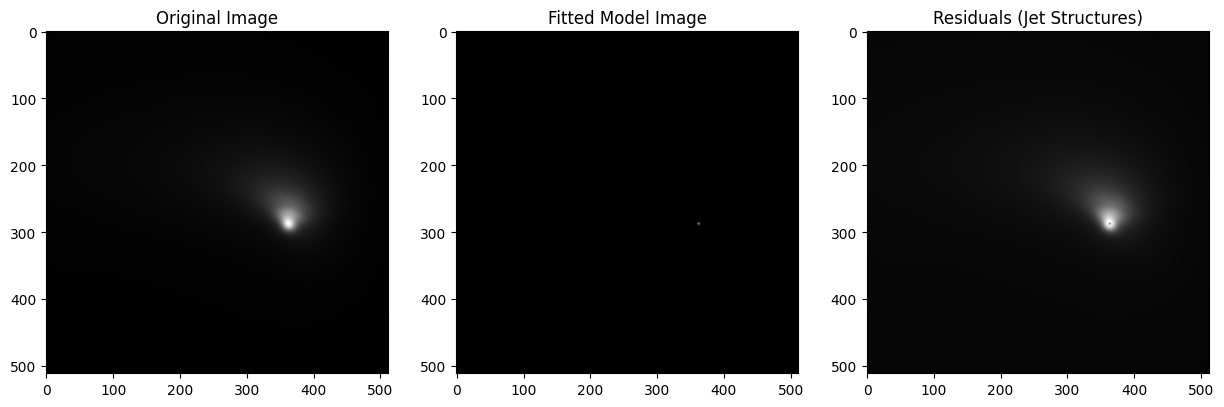

----------------------------------------------------------------
Model Parameters for hboppr02.fits: [ 0.03384211 -0.14114902]
----------------------------------------------------------------


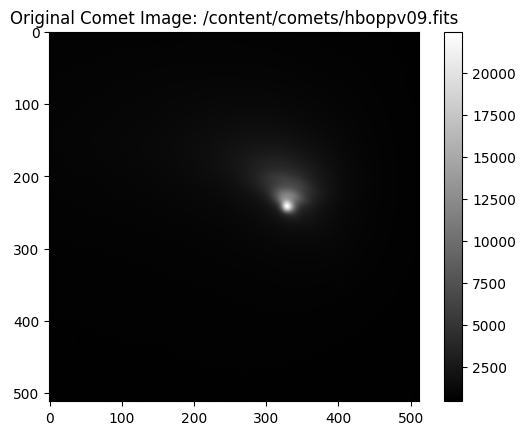

--------------------------------------------
Centroid: (242, 329), Peak Intensity: 22431
--------------------------------------------


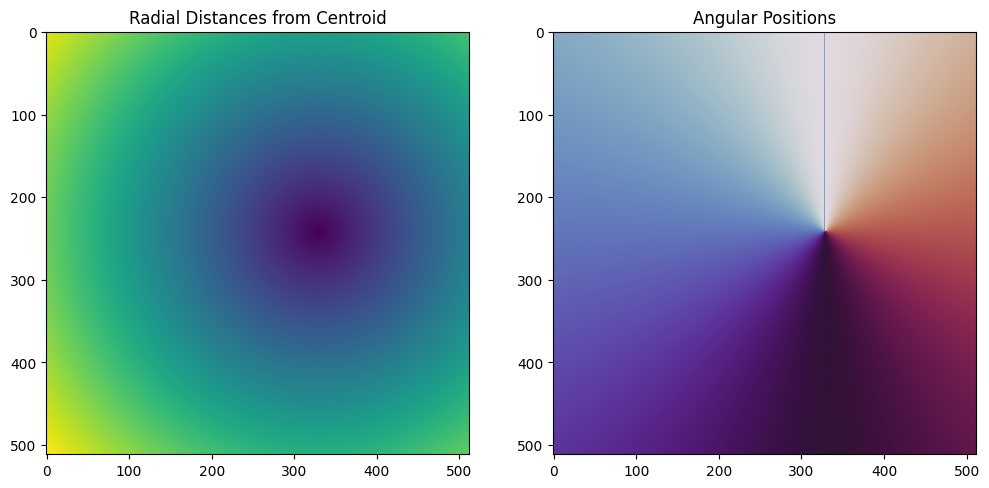

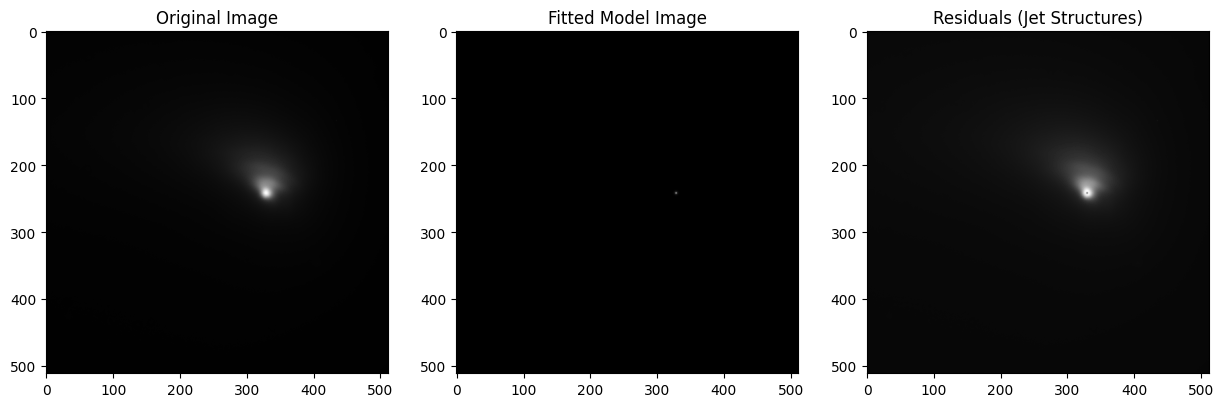

----------------------------------------------------------------
Model Parameters for hboppv09.fits: [ 0.03891876 -0.24338234]
----------------------------------------------------------------


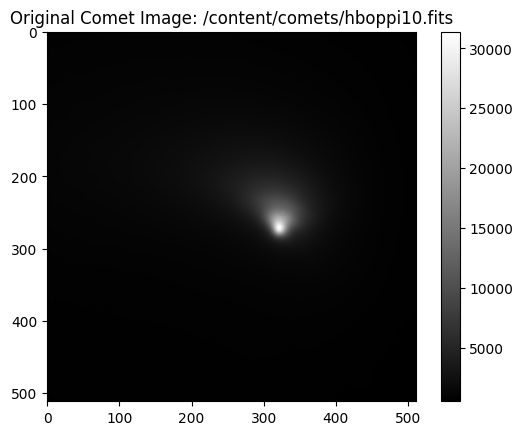

--------------------------------------------
Centroid: (271, 321), Peak Intensity: 31404
--------------------------------------------


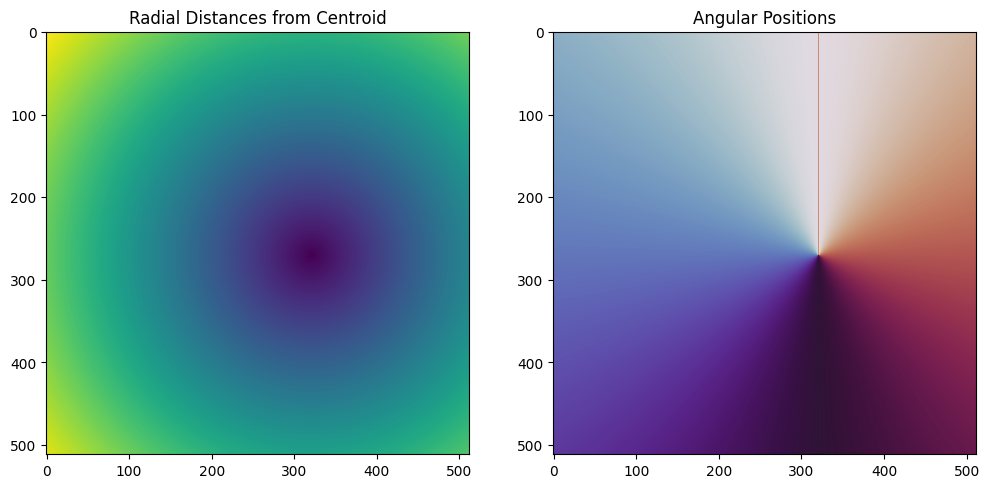

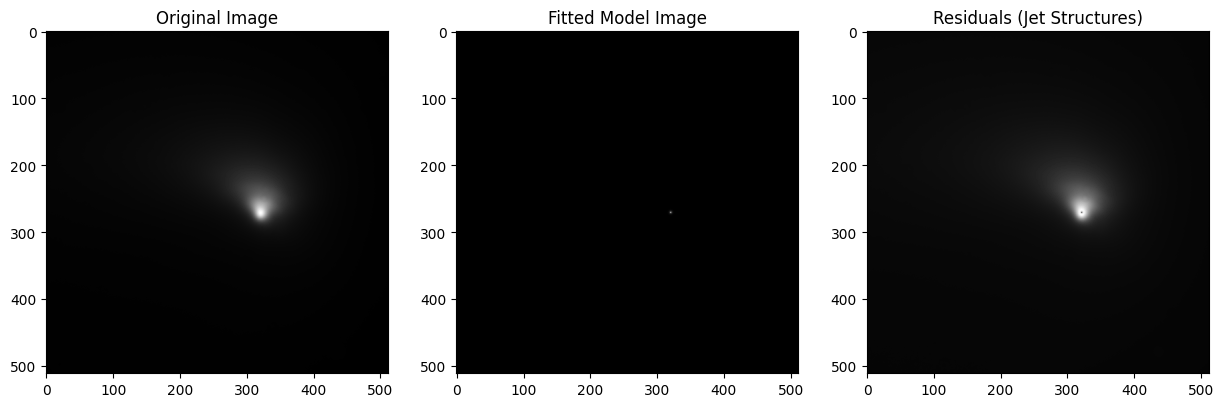

----------------------------------------------------------------
Model Parameters for hboppi10.fits: [ 0.03014726 -0.17604004]
----------------------------------------------------------------


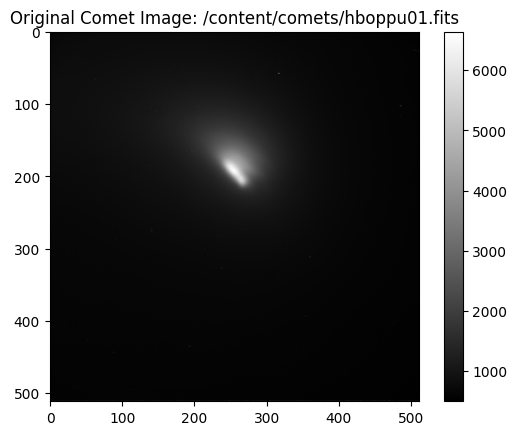

--------------------------------------------
Centroid: (193, 255), Peak Intensity: 6640
--------------------------------------------


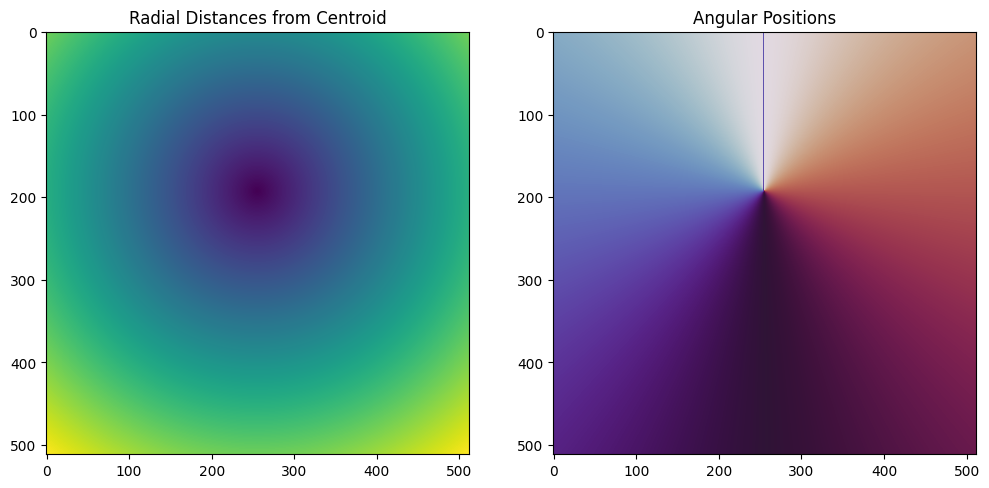

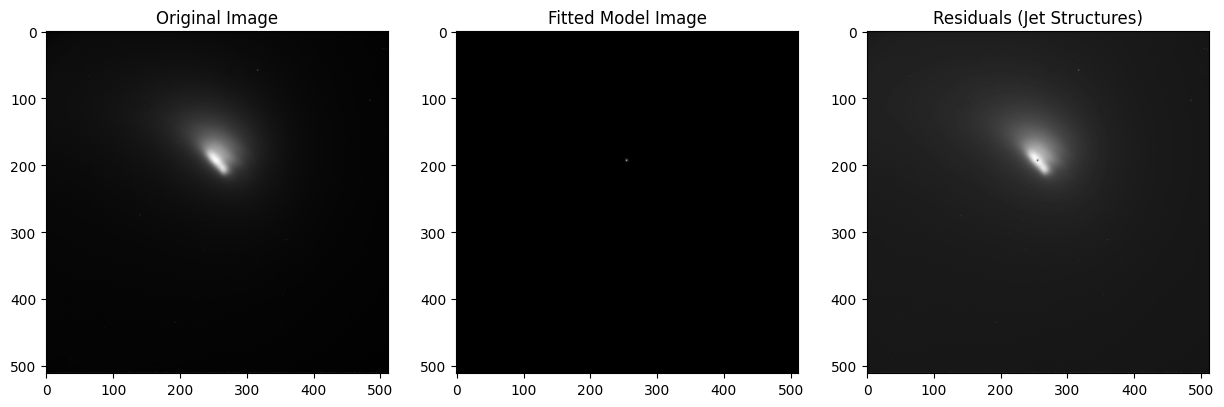

----------------------------------------------------------------
Model Parameters for hboppu01.fits: [0.00373422 0.03501008]
----------------------------------------------------------------


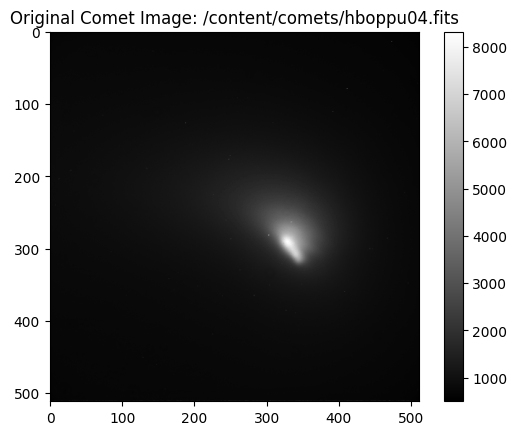

--------------------------------------------
Centroid: (291, 328), Peak Intensity: 8322
--------------------------------------------


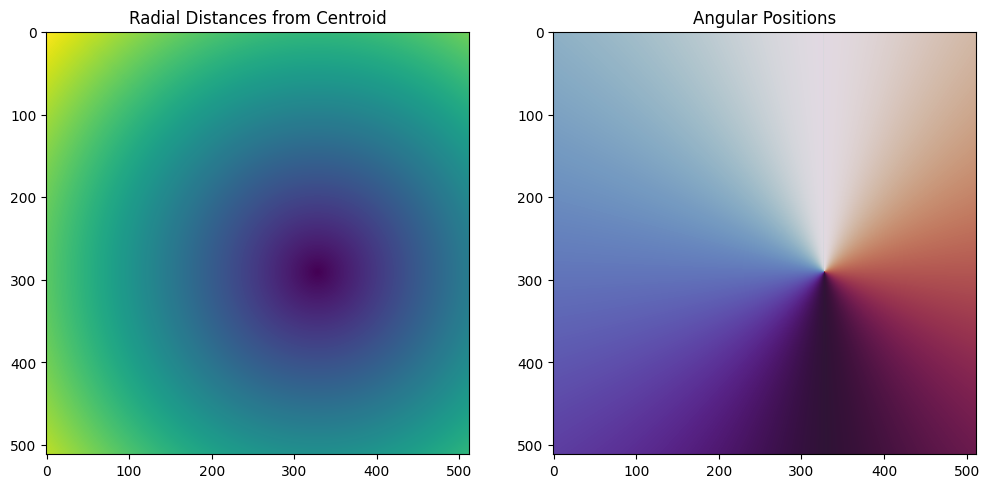

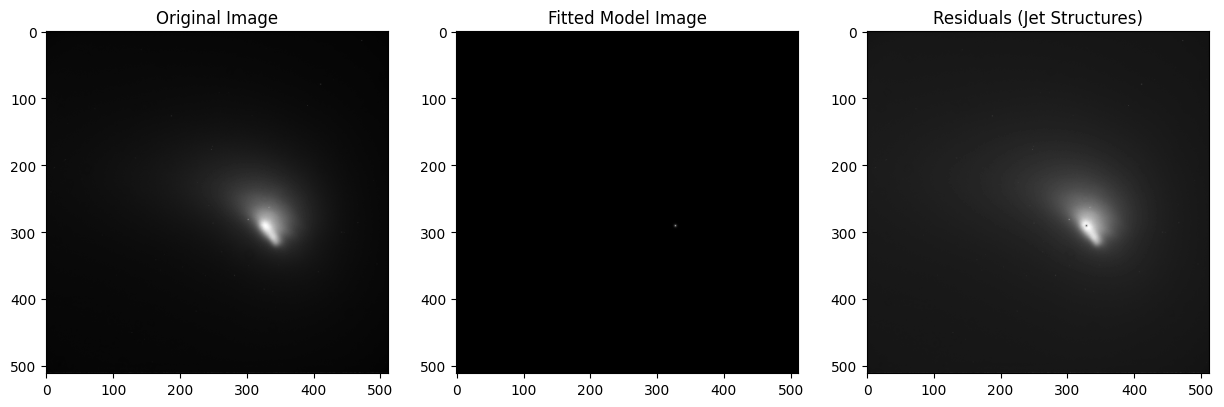

----------------------------------------------------------------
Model Parameters for hboppu04.fits: [0.00575361 0.09294524]
----------------------------------------------------------------


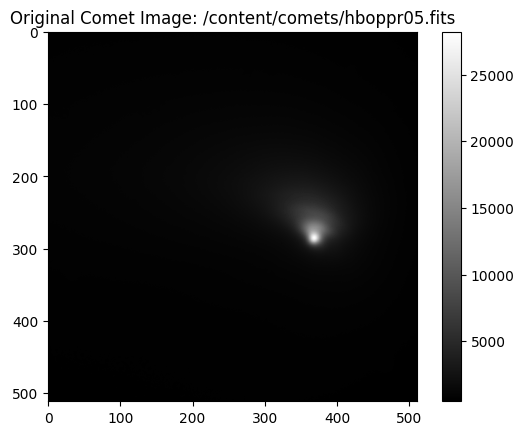

--------------------------------------------
Centroid: (285, 368), Peak Intensity: 28222
--------------------------------------------


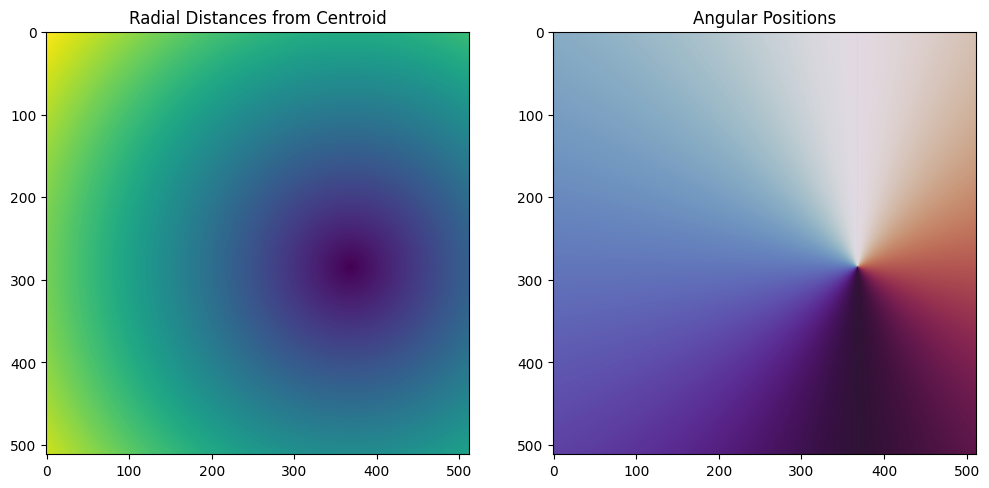

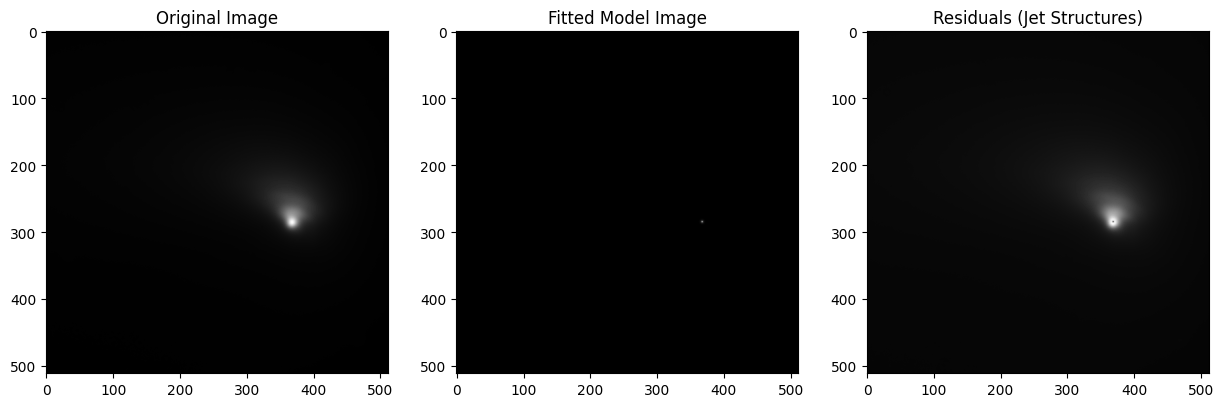

----------------------------------------------------------------
Model Parameters for hboppr05.fits: [ 0.03756153 -0.17982307]
----------------------------------------------------------------


In [80]:
def process_all_fits(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".fits"):
            fits_path = os.path.join(directory, filename)
            image_data, x0, y0, I0, rho, theta = process_fits(fits_path)
            model_image, residuals, params = fit_model(image_data, rho, theta, I0)

            # Visualize fitted model and residuals
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(image_data, cmap='gray')
            ax[0].set_title('Original Image')
            ax[1].imshow(model_image, cmap='gray')
            ax[1].set_title('Fitted Model Image')
            ax[2].imshow(residuals, cmap='gray')
            ax[2].set_title('Residuals (Jet Structures)')
            plt.show()

            # Print model parameters
            print(f"----------------------------------------------------------------")
            print(f"Model Parameters for {filename}: {params}")
            print(f"----------------------------------------------------------------")


# Example usage: process all FITS files in a directory
process_all_fits('/content/comets')
